# 1. Importing Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from datetime import datetime
from pylab import rcParams
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
import scipy.stats
import pylab

import statsmodels.api as sm
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.stattools import adfuller,grangercausalitytests
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.tsa.api import VAR

from arch import arch_model

from statsmodels.tsa.arima.model import ARIMA,ARIMAResults
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf,month_plot,quarter_plot
from statsmodels.tools.eval_measures import mse,rmse,meanabs

from pmdarima import auto_arima

# 2. Uploading Data

In [2]:
raw_data = pd.read_csv("GercekZamanliUretim-ATATURK-HES-40W000000000142N-01012020-31122022.csv")
raw_data.head()

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xf0 in position 33: invalid continuation byte

#### Dealing with UnicodeDecodeError

In [15]:
import chardet

with open("GercekZamanliUretim-ATATURK-HES-40W000000000142N-01012020-31122022.csv","rb") as x:
    result = chardet.detect(x.read())
    
print(list(result.keys())[0], ": ", list(result.values())[0])

encoding :  ISO-8859-1


In [16]:
raw_data = pd.read_csv("GercekZamanliUretim-ATATURK-HES-40W000000000142N-01012020-31122022.csv",encoding="ISO-8859-1")
raw_data.head()

,Tarih,Saat,Toplam (MWh),Doðal Gaz,Barajlý,Linyit,Akarsu,Ýthal Kömür,Rüzgar,Güneþ,Fuel Oil,Jeotermal,Asfaltit Kömür,Taþ Kömür,Biyokütle,Nafta,LNG,Uluslararasý,Atýk Isý
0,01.01.2020,00:00,"22,53","0,00","22,53","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
1,01.01.2020,01:00,"1,20","0,00","1,20","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
2,01.01.2020,02:00,"1,20","0,00","1,20","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
3,01.01.2020,03:00,"1,20","0,00","1,20","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
4,01.01.2020,04:00,"1,20","0,00","1,20","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"


In [17]:
raw_data.tail()

,Tarih,Saat,Toplam (MWh),Doðal Gaz,Barajlý,Linyit,Akarsu,Ýthal Kömür,Rüzgar,Güneþ,Fuel Oil,Jeotermal,Asfaltit Kömür,Taþ Kömür,Biyokütle,Nafta,LNG,Uluslararasý,Atýk Isý
26299,31.12.2022,19:00,"566,99","0,00","566,99","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
26300,31.12.2022,20:00,"552,84","0,00","552,84","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
26301,31.12.2022,21:00,"437,02","0,00","437,02","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
26302,31.12.2022,22:00,"580,28","0,00","580,28","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
26303,31.12.2022,23:00,"527,40","0,00","527,40","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"


# 3. Data Preprocessing

In [21]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26304 entries, 0 to 26303
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Tarih           26304 non-null  object
 1   Saat            26304 non-null  object
 2   Toplam (MWh)    26304 non-null  object
 3   Doðal Gaz       26304 non-null  object
 4   Barajlý         26304 non-null  object
 5   Linyit          26304 non-null  object
 6   Akarsu          26304 non-null  object
 7   Ýthal Kömür     26304 non-null  object
 8   Rüzgar          26304 non-null  object
 9   Güneþ           26304 non-null  object
 10  Fuel Oil        26304 non-null  object
 11  Jeotermal       26304 non-null  object
 12  Asfaltit Kömür  26304 non-null  object
 13  Taþ Kömür       26304 non-null  object
 14  Biyokütle       26304 non-null  object
 15  Nafta           26304 non-null  object
 16  LNG             26304 non-null  object
 17  Uluslararasý    26304 non-null  object
 18  Atýk I

In [22]:
# Converting "Toplam (MWh)" column type to float
raw_data["Toplam (MWh)"] = raw_data["Toplam (MWh)"].str.replace('.', '').str.replace(',', '.').astype(float)
raw_data.head()

,Tarih,Saat,Toplam (MWh),Doðal Gaz,Barajlý,Linyit,Akarsu,Ýthal Kömür,Rüzgar,Güneþ,Fuel Oil,Jeotermal,Asfaltit Kömür,Taþ Kömür,Biyokütle,Nafta,LNG,Uluslararasý,Atýk Isý
0,01.01.2020,00:00,22.53,"0,00","22,53","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
1,01.01.2020,01:00,1.20,"0,00","1,20","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
2,01.01.2020,02:00,1.20,"0,00","1,20","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
3,01.01.2020,03:00,1.20,"0,00","1,20","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
4,01.01.2020,04:00,1.20,"0,00","1,20","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"


In [23]:
# Removing unnecessary columns
df = raw_data[["Tarih","Toplam (MWh)"]]
df

,Tarih,Toplam (MWh)
0,01.01.2020,22.53
1,01.01.2020,1.20
2,01.01.2020,1.20
3,01.01.2020,1.20
4,01.01.2020,1.20
...,...,...
26299,31.12.2022,566.99
26300,31.12.2022,552.84
26301,31.12.2022,437.02
26302,31.12.2022,580.28


In [26]:
# grouping for calculation of daily production

df = df.groupby("Tarih")["Toplam (MWh)"].sum()
df = pd.DataFrame(df)
df

,Toplam (MWh)
Tarih,
01.01.2020,5904.47
01.01.2021,7726.36
01.01.2022,19027.27
01.02.2020,21690.19
01.02.2021,3543.76
...,...
31.10.2021,10652.17
31.10.2022,9046.84
31.12.2020,6813.52


In [29]:
# Taking care of date type
df.index = pd.to_datetime(df.index,dayfirst = True) 
df = df.asfreq('d')                                
df.columns = ["Toplam"]
df

,Toplam
Tarih,
2020-01-01,5904.47
2020-01-02,25185.71
2020-01-03,28253.62
2020-01-04,33769.15
2020-01-05,25722.53
...,...
2022-12-27,7893.99
2022-12-28,7574.78
2022-12-29,8556.38


In [30]:
# Checking data
df.isnull().sum()

Toplam    0
dtype: int64

In [31]:
# Checking index type and freq
df.index

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2022-12-22', '2022-12-23', '2022-12-24', '2022-12-25',
               '2022-12-26', '2022-12-27', '2022-12-28', '2022-12-29',
               '2022-12-30', '2022-12-31'],
              dtype='datetime64[ns]', name='Tarih', length=1096, freq='D')

# 4. Plotting Data

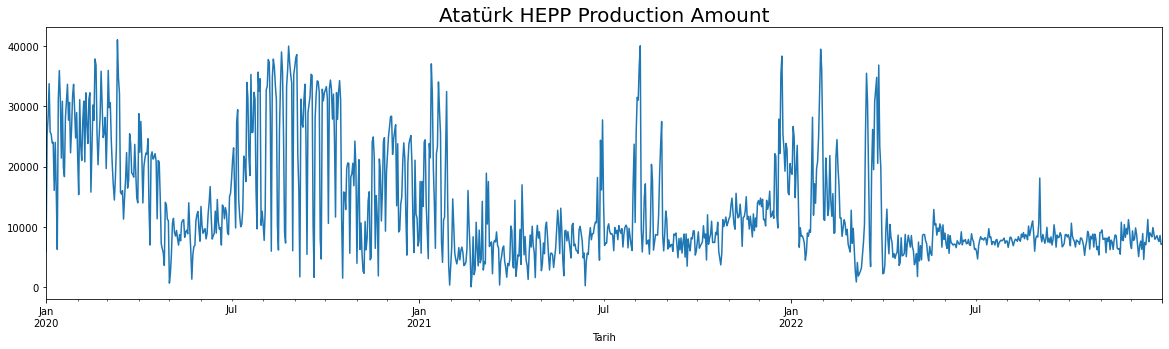

In [33]:
df.Toplam.plot(figsize=(20,5))
plt.title("Atatürk HEPP Production Amount",fontsize=20)
plt.show()

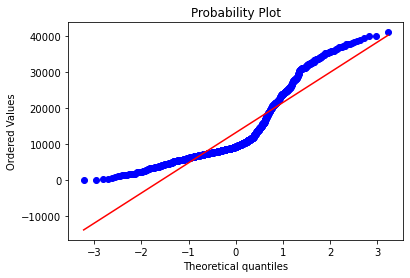

In [34]:
scipy.stats.probplot(df.Toplam,plot=pylab)
pylab.show()

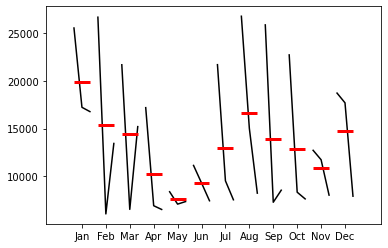

In [35]:
df_m = df.Toplam.resample(rule="M").mean()
month_plot(df_m);

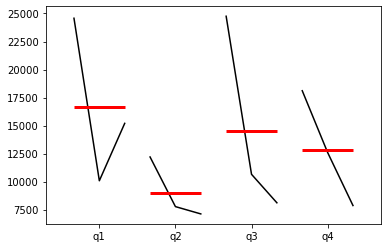

In [37]:
df_q = df.Toplam.resample(rule="Q").mean()
quarter_plot(df_q);

# 5. Seasonal Decompose

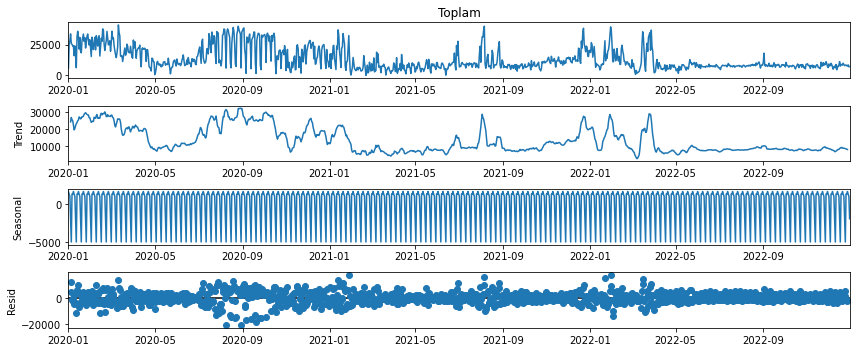

In [38]:
result = seasonal_decompose(df.Toplam,model="add")  
rcParams["figure.figsize"] = 12,5
result.plot();

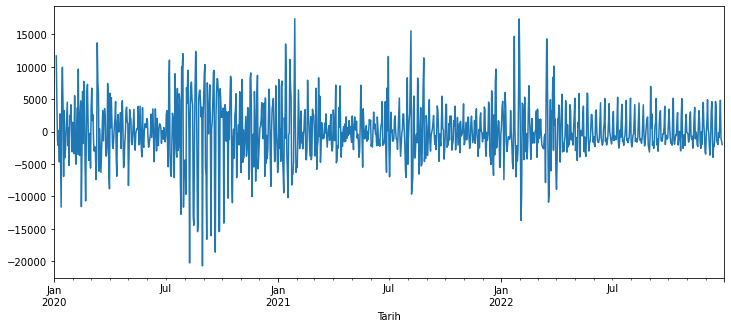

In [39]:
result.resid.plot();

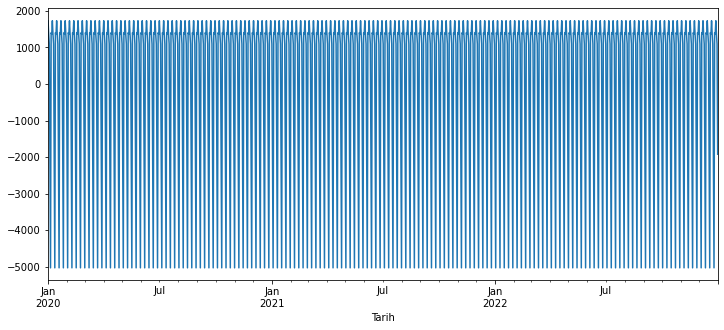

In [40]:
result.seasonal.plot();

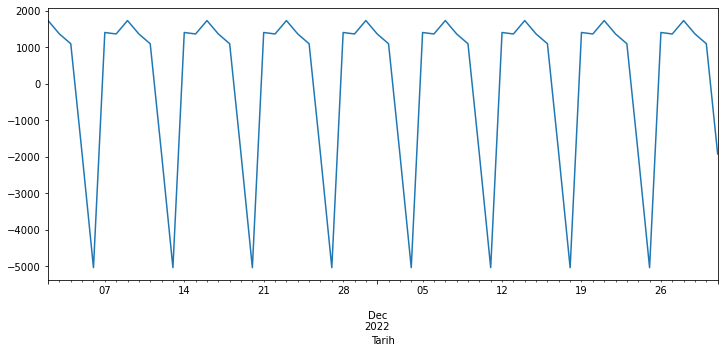

In [42]:
result.seasonal.iloc[-60:].plot();

# 6. Dickey-Fuller Test For Stationarity

In [43]:
def adf_test(series):

    print(f'Augmented Dickey-Fuller Test:')
    result = adfuller(series.dropna(),autolag='AIC') 
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [44]:
adf_test(df.Toplam)

Augmented Dickey-Fuller Test:
ADF test statistic        -3.197422
p-value                    0.020134
# lags used               21.000000
# observations          1074.000000
critical value (1%)       -3.436453
critical value (5%)       -2.864235
critical value (10%)      -2.568205
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


# 7. ACF - PACF - LAG PLOT

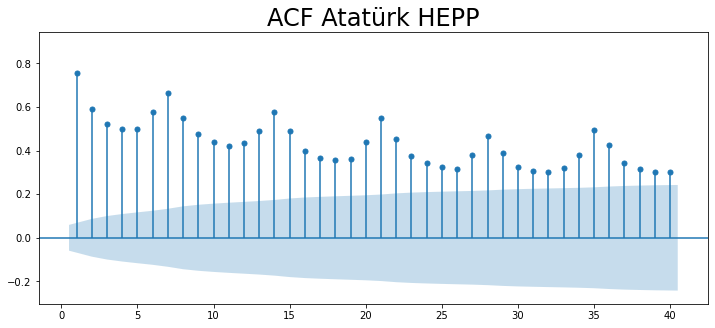

In [45]:
plot_acf(df.Toplam,lags=40,zero=False,auto_ylims=True)
plt.title("ACF Atatürk HEPP",size=24)
plt.show()

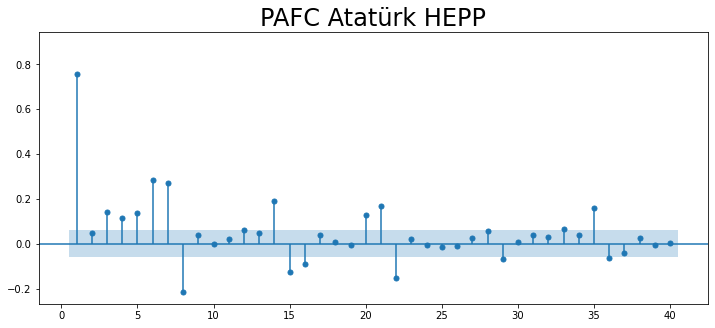

In [46]:
plot_pacf(df.Toplam,lags=40,zero=False,method=("ols"),auto_ylims=True)
plt.title("PAFC Atatürk HEPP",size=24)
plt.show()

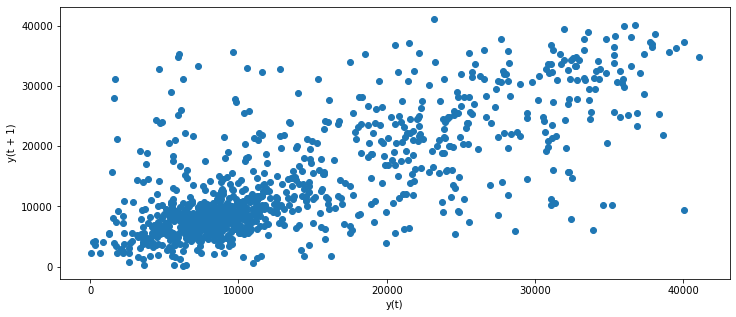

In [47]:
lag_plot(df.Toplam);